# OSSL vs Ringtrial

> Explorative Data Analysis of OSSL vs Ringtrial


In [64]:
%load_ext autoreload
%autoreload 2

In [65]:
import pandas as pd
from pathlib import Path

from sklearn.metrics import r2_score
from uhina.loading import LoaderFactory, plot_spectra
from uhina.preprocessing import TakeDerivative, SNV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

import plotly
import plotly.express as px
import numpy as np
from astartes import train_val_test_split

## Loading data

X shape: (1400, 1676)


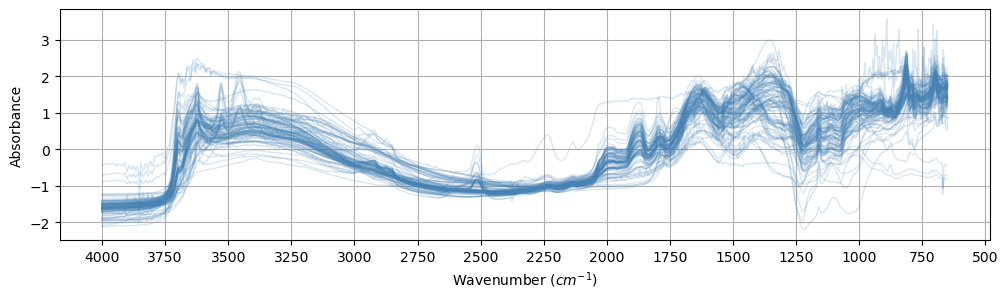

In [66]:
src = Path.home() / 'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001'
loader = LoaderFactory.get_loader(src, 'ringtrial')
data_rt = loader.load_data(analytes='potassium_cmolkg')
data_rt.ds = np.array([s.split('-rt')[0] for s in data_rt.sample_indices])
print(f'X shape: {data_rt.X.shape}')

plot_spectra(data_rt, n_spectra=100, snv=True, alpha=0.2, figsize=(12, 3));

In [67]:
src = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'
loader = LoaderFactory.get_loader(src, 'ossl', spectra_type='mir')
data_ossl = loader.load_data(analytes='k.ext_usda.a725_cmolc.kg')
print(f'X shape: {data_ossl.X.shape}')

Loading data from /Users/franckalbinet/.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz ...
X shape: (57674, 1676)


(<Figure size 1200x300 with 1 Axes>,
 <Axes: xlabel='Wavenumber ($cm^{-1}$)', ylabel='Absorbance'>)

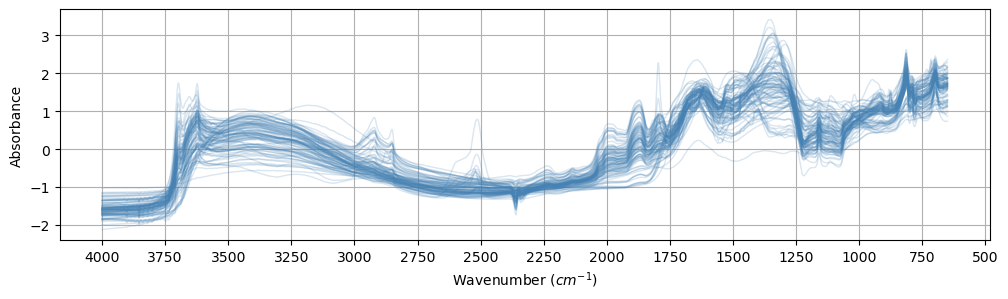

In [68]:
plot_spectra(data_ossl, n_spectra=100, snv=True, alpha=0.2, figsize=(12, 3))

In [69]:
def pca_rt_ossl(data_rt, data_ossl):
    # Combine the spectra from both datasets
    X_combined = np.vstack((data_rt.X, data_ossl.X))
    
    # Create the pipeline
    pipe = Pipeline([
        ('SNV', SNV()),
        ('Derivative', TakeDerivative()),
        ('Scaler', StandardScaler()),  
        ('PCA', PCA(n_components=3))
    ])

    # Fit and transform the combined data
    X_pca_combined = pipe.fit_transform(X_combined)
    
    # Split the results back into rt and ossl
    data_rt.X_pca = X_pca_combined[:data_rt.X.shape[0]]
    data_ossl.X_pca = X_pca_combined[data_rt.X.shape[0]:]
    
    return data_rt, data_ossl

In [70]:
data_rt, data_ossl = pca_rt_ossl(data_rt, data_ossl)

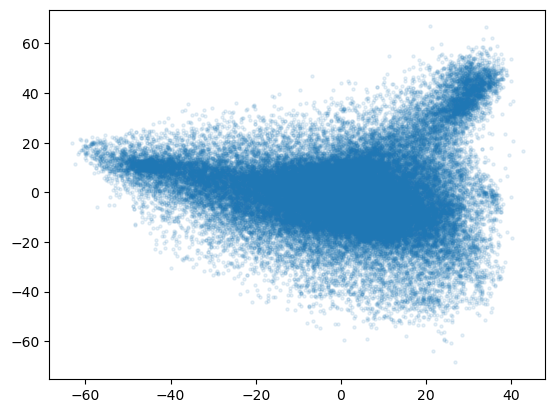

In [96]:
from matplotlib import pyplot as plt
plt.scatter(data_ossl.X_pca[:, 0], data_ossl.X_pca[:, 1], s=5, alpha=0.1)


In [72]:
n_samples = 100
idx = np.random.choice(data_ossl.X_pca.shape[0], 
                       size=n_samples, replace=False)

X_ossl_subset = data_ossl.X_pca[idx]

In [73]:
lut_ossl_ds = {i: ds for i, ds in enumerate(data_ossl.dataset_labels)}


In [74]:
data_ossl.dataset_names

array([0, 0, 0, ..., 3, 3, 3])

In [75]:
np.vectorize(lut_ossl_ds.get)(data_ossl.dataset_names)

array(['GARRETT.SSL', 'GARRETT.SSL', 'GARRETT.SSL', ...,
       'LUCAS.WOODWELL.SSL', 'LUCAS.WOODWELL.SSL', 'LUCAS.WOODWELL.SSL'],
      dtype='<U18')

In [76]:
data_rt.X_pca

array([[-37.57209416,  10.0194439 ,   1.41901894],
       [ 24.05922823,  10.83135662,  12.43538485],
       [  8.09090194, -26.63507173,   7.36763935],
       ...,
       [  8.44862862,  -4.47373073,   2.51161567],
       [ 15.9657049 ,   8.60238863, -19.86332133],
       [  2.45832757,   6.53856188,   3.22457499]])

In [77]:
mask_rt_ds = data_rt.ds == 'kssl'

In [106]:
data_ossl.X_pca

array([[  2.45822505,  16.4823169 ,   9.00422903],
       [ -2.36297831,  10.87565108,   7.6014877 ],
       [ -4.66533181,  11.81300838,   7.77196598],
       ...,
       [ 33.2311886 ,  -6.53547903,   8.0031913 ],
       [  8.18561655,  24.05135848,  14.03594385],
       [-11.41377595,   8.67332126,  -6.78131327]])

In [230]:
def data_to_df(data_ossl, data_rt, 
               n_samples_ossl=100, rt_ds='kssl',
               cols=['PC1', 'PC2', 'PC3']):
    lut_ossl_ds = {i: ds for i, ds in enumerate(data_ossl.dataset_labels)}
    idx = np.random.choice(data_ossl.X_pca.shape[0], size=n_samples_ossl, replace=False)
    X_ossl_subset = data_ossl.X_pca[idx,:]
    ds_ossl = np.vectorize(lut_ossl_ds.get)(data_ossl.dataset_names[idx])
    
    df_ossl = pd.DataFrame(X_ossl_subset, columns=cols)
    df_ossl['ds'] = ds_ossl
    # return df_ossl
    
    mask = data_rt.ds == rt_ds
    
    X_rt = data_rt.X_pca[mask]
    df_rt = pd.DataFrame(X_rt, columns=cols)
    df_rt['ds'] = rt_ds + '-rt'
    # df_rt = pd.DataFrame(np.c_[X_rt, np.full(np.sum(mask), rt_ds + '-rt')], columns=cols)
    
    return pd.concat([df_ossl, df_rt], axis=0, ignore_index=True)

In [231]:
df = data_to_df(data_ossl, data_rt, n_samples_ossl=200)

In [232]:
def plot_scatter3d(df, size_dict=None, default_opacity=0.7):
    """
    Generates a nicely formatted 3D scatter plot of the data with different symbols, colors, and sizes for each dataset.

    Args:
        df (pd.DataFrame): DataFrame containing the data with columns 'PC1', 'PC2', 'PC3', 'ds'
        size_dict (dict, optional): Dictionary mapping dataset names to dot sizes. Defaults to None.
        default_opacity (float, optional): Default opacity for all points. Defaults to 0.7.
    """
    # Default size
    default_size = 20

    # If size_dict is not provided, initialize it with default values
    if size_dict is None:
        size_dict = {}

    # Create dot_size column based on the ds column, using defaults if not in dict
    df['dot_size'] = df['ds'].map(lambda x: size_dict.get(x, default_size))

    fig = px.scatter_3d(
        df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='ds',
        symbol='ds',
        size='dot_size',
        opacity=default_opacity,
        hover_data=['ds'],
        color_discrete_sequence=px.colors.qualitative.Set1,
    )

    fig.update_traces(marker=dict(line=dict(width=0)))

    fig.update_layout(
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        legend_title='Dataset',
        height=800,
        width=1000,
    )

    fig.show()

In [233]:
data_ossl.dataset_labels

array(['GARRETT.SSL', 'ICRAF.ISRIC', 'KSSL.SSL', 'LUCAS.WOODWELL.SSL'],
      dtype=object)

In [234]:
np.unique(data_rt.ds)

array(['agrocares', 'argonne', 'csu-il', 'eth-alpha-1', 'eth-alpha-2',
       'eth-vertex', 'iaea-aug2022', 'kssl', 'landcare', 'lesotho', 'msu',
       'osu', 'rothamsted', 'scion', 'ughent', 'uiuc', 'usp',
       'uwisc-fine', 'woodwell-alpha', 'woodwell-vertex'], dtype='<U15')

In [235]:
size_dict = {
    'KSSL.SSL': 1,
    'GARRETT.SSL': 3,
    'ICRAF.ISRIC': 3,
    'LUCAS.WOODWELL.SSL': 3,
    
}

plot_scatter3d(
    data_to_df(data_ossl, data_rt, n_samples_ossl=5000,  rt_ds='iaea-aug2022'), 
    size_dict=size_dict)